In [1]:
# On affiche les graphiques dans le notebook en statique
%matplotlib inline

In [24]:
"""
code du lightgbm repris (et adapté) de :
Lien : https://www.kaggle.com/code/jsaguiar/lightgbm-7th-place-solution

KAGGLE HOME CREDIT DEFAULT RISK COMPETITION
Adapted from one of the models used in 7th place solution ensemble.
For more details about our solution please check this discussion:
https://www.kaggle.com/c/home-credit-default-risk/discussion/64580

Another similar version is also available at GitHub:
https://github.com/js-aguiar/home-credit-default-competition

This model uses LightGBM with goss and label encode for the application's 
categorical features. Other tables are using one-hot encode with mean, 
sum and a few different functions to aggregate. The main ideia was to add 
more time related features like last application and last X months aggregations.
There are also aggregations for specific loan types and status as well as
ratios between tables. Configurations are in line 785
"""

import os
import gc
import time
import numpy as np
import pandas as pd
import re
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from contextlib import contextmanager
import multiprocessing as mp
from functools import partial
from scipy.stats import kurtosis, iqr, skew
import lightgbm as lgb
from lightgbm import LGBMClassifier
import sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.metrics import roc_auc_score, confusion_matrix, roc_curve
import warnings

from pprint import pprint
import mlflow 
import mlflow.sklearn
from mlflow import MlflowClient

warnings.simplefilter(action="ignore", category=FutureWarning)

In [3]:
from src.p7_lightgbm import get_age_label, get_bureau, get_data
from src.p7_lightgbm import add_ratios_features, reduce_memory, timer, kfold_lightgbm_sklearn
from src.p7_lightgbm import display_importances
from src.p7_constantes import (
    NUM_THREADS,
    SUBMISSION_SUFIX,
    INSTALLMENTS_LAST_K_TREND_PERIODS,
    GENERATE_SUBMISSION_FILES,
    STRATIFIED_KFOLD,
    RANDOM_SEED,
    NUM_FOLDS,
    EARLY_STOPPING,
    MODEL_DIR,
    DATA_BASE,
    DATA_INTERIM,
)

%load_ext autoreload
%autoreload 2
#autoreload 2 = Reload all modules (except those excluded by %aimport)
# every time before executing the Python code typed.

In [4]:
print("Numpy: {}".format(np.__version__))
print("Pandas: {}".format(pd.__version__))
print("Scikit-learn: {}".format(sklearn.__version__))
print("MLFlow: {}".format(mlflow.__version__))

Numpy: 1.26.4
Pandas: 2.2.2
Scikit-learn: 1.4.2
MLFlow: 2.12.1


# Séléction des features à conserver

Démarrer

In [5]:
feature_importance = pd.read_csv(os.path.join(MODEL_DIR, "feature_importance_model2_04.csv"))

Features à conserver

In [6]:
top = 14
top = 18
features = feature_importance.sort_values(by='split', ascending=False).head(top)['feature'].values.tolist()
features

['ORGANIZATION_TYPE',
 'CREDIT_TO_ANNUITY_RATIO',
 'EXT_SOURCES_MEAN',
 'EXT_SOURCE_3',
 'DAYS_BIRTH',
 'EXT_SOURCES_NANMEDIAN',
 'EXT_SOURCES_MIN',
 'BUREAU_CONSUMER_DAYS_CREDIT_ENDDATE_MAX',
 'EXT_SOURCE_1',
 'AMT_ANNUITY',
 'CREDIT_TO_GOODS_RATIO',
 'OCCUPATION_TYPE',
 'EXT_SOURCE_2',
 'EXT_SOURCES_MAX',
 'DAYS_ID_PUBLISH',
 'DAYS_EMPLOYED',
 'BUREAU_CREDIT_DEBT_CREDIT_DIFF_MEAN',
 'BUREAU_ACTIVE_DEBT_CREDIT_DIFF_MEAN']

In [7]:
"""
"feature": "ORGANIZATION_TYPE", "table": "application", "description": "Type of organization where client works", "agg": None

CREDIT_TO_ANNUITY_RATIO:
bureau["CREDIT_TO_ANNUITY_RATIO"] = bureau["AMT_CREDIT_SUM"] / bureau["AMT_ANNUITY"]
prev["CREDIT_TO_ANNUITY_RATIO"] = prev["AMT_CREDIT"] / prev["AMT_ANNUITY"]
(df=Application) df["CREDIT_TO_ANNUITY_RATIO"] = df["AMT_CREDIT"] / df["AMT_ANNUITY"]

"feature": "AMT_CREDIT", "table": "application", "description": "Credit amount of the loan", "agg": None
"feature": "AMT_ANNUITY", "table": "application", "description": "Loan annuity", "agg": None

EXT_SOURCES_MEAN
for function_name in ["min", "max", "mean", "nanmedian", "var"]:
        feature_name = "EXT_SOURCES_{}".format(function_name.upper())
        df[feature_name] = eval("np.{}".format(function_name))(
            df[["EXT_SOURCE_1", "EXT_SOURCE_2", "EXT_SOURCE_3"]], axis=1
        )

On va éviter une multicolinéarité trop forte en ne prenant pas toutes les features ext_sources. On va garder la EXT_SOURCES_MEAN et la EXT_SOURCE_3
"feature": "EXT_SOURCE_1", "table": "application", "description": "Normalized score from external data source", "agg": "None"
"feature": "EXT_SOURCE_2", "table": "application", "description": "Normalized score from external data source", "agg": "None"
"feature": "EXT_SOURCE_3", "table": "application", "description": "Normalized score from external data source", "agg": "None"

"feature": "DAYS_BIRTH", "table": "application", "description": "Client's age in days at the time of application", "agg": "None"

"feature": "DAYS_CREDIT_ENDDATE", "table": "bureau", "description": "Remaining duration of CB credit (in days) at the time of application in Home Credit", "agg": "max"

# On ne garde pas AMT_ANNUITY ?? Faire une matrice de corrélation ?
"feature": "AMT_ANNUITY", "table": "application", "description": "Loan annuity", "agg": "None"

CREDIT_TO_GOODS_RATIO
df["CREDIT_TO_GOODS_RATIO"] = df["AMT_CREDIT"] / df["AMT_GOODS_PRICE"]
"feature": "AMT_CREDIT", "table": "application", "description": "Credit amount of the loan", "agg": "None"
"feature": "AMT_GOODS_PRICE", "table": "application", "description": "For consumer loans it is the price of the goods for which the loan is given", "agg": "None"


"feature": "OCCUPATION_TYPE", "table": "application", "description": "What kind of occupation does the client have", "agg": "None"

"feature": "DAYS_ID_PUBLISH", "table": "application", "description": "How many days before the application did client change the identity document with which he applied for the loan", "agg": "None"

"feature": "DAYS_EMPLOYED", "table": "application", "description": "How many days before the application the person started current employment", "agg": "None"

BUREAU_CREDIT_DEBT_CREDIT_DIFF_MEAN
bureau["DEBT_CREDIT_DIFF"] = (
        bureau["AMT_CREDIT_SUM"] - bureau["AMT_CREDIT_SUM_DEBT"]
    )
    
# General loans aggregations
    agg_bureau = group(bureau, "BUREAU_", BUREAU_AGG)
    # Active and closed loans aggregations
    active = bureau[bureau["CREDIT_ACTIVE_Active"] == 1]
    agg_bureau = group_and_merge(
        active, agg_bureau, "BUREAU_ACTIVE_", BUREAU_ACTIVE_AGG
    )
BUREAU_AGG = {
    "DEBT_CREDIT_DIFF": ["mean", "sum"],
    
"feature": "AMT_CREDIT_SUM", "table": "bureau", "description": "Current credit amount for the Credit Bureau credit", "agg": "None"
"feature": "AMT_CREDIT_SUM_DEBT", "table": "bureau", "description": "Current debt on Credit Bureau credit", "agg": "None"  
    
    
Pour le Last loan, c'est intéressant mais plus compliqué. A priori ce serait le nombre de jours d'impayés du dernier emprunt précédent
installments_payments.csv
pay["DPD"] = pay["DAYS_ENTRY_PAYMENT"] - pay["DAYS_INSTALMENT"]
    pay["DPD"] = pay["DPD"].apply(lambda x: 0 if x <= 0 else x)
DAYS_ENTRY_PAYMENT : When was the installments of previous credit paid actually (relative to application date of current loan)
DAYS_INSTALMENT : When the installment of previous credit was supposed to be paid (relative to application date of current loan)
"""

'\n"feature": "ORGANIZATION_TYPE", "table": "application", "description": "Type of organization where client works", "agg": None\n\nCREDIT_TO_ANNUITY_RATIO:\nbureau["CREDIT_TO_ANNUITY_RATIO"] = bureau["AMT_CREDIT_SUM"] / bureau["AMT_ANNUITY"]\nprev["CREDIT_TO_ANNUITY_RATIO"] = prev["AMT_CREDIT"] / prev["AMT_ANNUITY"]\n(df=Application) df["CREDIT_TO_ANNUITY_RATIO"] = df["AMT_CREDIT"] / df["AMT_ANNUITY"]\n\n"feature": "AMT_CREDIT", "table": "application", "description": "Credit amount of the loan", "agg": None\n"feature": "AMT_ANNUITY", "table": "application", "description": "Loan annuity", "agg": None\n\nEXT_SOURCES_MEAN\nfor function_name in ["min", "max", "mean", "nanmedian", "var"]:\n        feature_name = "EXT_SOURCES_{}".format(function_name.upper())\n        df[feature_name] = eval("np.{}".format(function_name))(\n            df[["EXT_SOURCE_1", "EXT_SOURCE_2", "EXT_SOURCE_3"]], axis=1\n        )\n\nOn va éviter une multicolinéarité trop forte en ne prenant pas toutes les features

# Script get data pour analyse exploratoire

In [8]:
APPLICATION_FEATURES = [
    "SK_ID_CURR",
    "ORGANIZATION_TYPE",
    "AMT_CREDIT",
    "AMT_ANNUITY",
    "EXT_SOURCE_1",
    "EXT_SOURCE_2",
    "EXT_SOURCE_3",
    "DAYS_BIRTH",
    "AMT_GOODS_PRICE",
    "OCCUPATION_TYPE",
    "DAYS_ID_PUBLISH",
    "DAYS_EMPLOYED",
    "AMT_INCOME_TOTAL", # Pas dans importante dans la feature importance
    ]

BUREAU_FEATURES = [
    "SK_ID_CURR",
    "DAYS_CREDIT_ENDDATE",
    "AMT_CREDIT_SUM",
    "AMT_CREDIT_SUM_DEBT",
    ]

In [9]:
def get_important_application(path=DATA_BASE, num_rows=None):
    """Process application_train.csv and application_test.csv and return a pandas dataframe."""
    train = pd.read_csv(os.path.join(path, "application_train.csv"), nrows=num_rows)[APPLICATION_FEATURES + ['TARGET']]
    test = pd.read_csv(os.path.join(path, "application_test.csv"), nrows=num_rows)[APPLICATION_FEATURES]
    df = pd.concat([train, test], ignore_index=True)
    del train, test
    gc.collect()
    
    # Data cleaning
    if "AMT_INCOME_TOTAL" in APPLICATION_FEATURES:
        df = df[
            df["AMT_INCOME_TOTAL"] < 20000000
    ]  # Max income in test is 4M; train has a 117M value
    df["DAYS_EMPLOYED"].replace(365243, np.nan, inplace=True)

    # Categorical age - based on target=1 plot
    df["AGE_RANGE"] = df["DAYS_BIRTH"].apply(lambda x: get_age_label(x))
    
    # Age  comme var numérique (plus compréhensible que day_birth)
    df["AGE"] = - df["DAYS_BIRTH"] / 365


    # np.warnings.filterwarnings("ignore", r"All-NaN (slice|axis) encountered")
    np.seterr(all="ignore", invalid="ignore")
    # New features based on External sources
    df["EXT_SOURCES_MEAN"] = np.mean(df[["EXT_SOURCE_1", "EXT_SOURCE_2", "EXT_SOURCE_3"]], axis=1)
    df["EXT_SOURCES_NANMEDIAN"] = np.nanmedian(df[["EXT_SOURCE_1", "EXT_SOURCE_2", "EXT_SOURCE_3"]], axis=1)
    # Credit ratios
    df["CREDIT_TO_ANNUITY_RATIO"] = df["AMT_CREDIT"] / df["AMT_ANNUITY"]
    df["CREDIT_TO_GOODS_RATIO"] = df["AMT_CREDIT"] / df["AMT_GOODS_PRICE"]
    # Income ratios
    if "AMT_INCOME_TOTAL" in APPLICATION_FEATURES:
        df["ANNUITY_TO_INCOME_RATIO"] = df["AMT_ANNUITY"] / df["AMT_INCOME_TOTAL"]

    to_drop = ['DAYS_BIRTH', 'AMT_CREDIT','EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCES_NANMEDIAN', 'AMT_INCOME_TOTAL', 'AGE_RANGE', 'AMT_GOODS_PRICE']
    df = df.drop(to_drop, axis=1)
    
    # Encode categorical features (LabelEncoder)
    """df, le_encoded_cols = label_encoder(df, None)
    df = drop_application_columns(df)"""
    return df
    

In [10]:
application = get_important_application()
application.head()

D:\TEMP\ipykernel_5696\2728051136.py:27: RuntimeWarning: All-NaN slice encountered
  df["EXT_SOURCES_NANMEDIAN"] = np.nanmedian(df[["EXT_SOURCE_1", "EXT_SOURCE_2", "EXT_SOURCE_3"]], axis=1)


,SK_ID_CURR,ORGANIZATION_TYPE,AMT_ANNUITY,EXT_SOURCE_3,OCCUPATION_TYPE,DAYS_ID_PUBLISH,DAYS_EMPLOYED,TARGET,AGE,EXT_SOURCES_MEAN,CREDIT_TO_ANNUITY_RATIO,CREDIT_TO_GOODS_RATIO,ANNUITY_TO_INCOME_RATIO
0,100002,Business Entity Type 3,24700.5,0.139376,Laborers,-2120,-637.0,1.0,25.920548,0.161787,16.461104,1.158397,0.121978
1,100003,School,35698.5,NaN,Core staff,-291,-1188.0,0.0,45.931507,0.466757,36.234085,1.145199,0.132217
2,100004,Government,6750.0,0.729567,Laborers,-2531,-225.0,0.0,52.180822,0.642739,20.000000,1.000000,0.100000
3,100006,Business Entity Type 3,29686.5,NaN,Laborers,-2437,-3039.0,0.0,52.068493,0.650442,10.532818,1.052803,0.219900
4,100007,Religion,21865.5,NaN,Core staff,-3458,-3038.0,0.0,54.608219,0.322738,23.461618,1.000000,0.179963


In [11]:
features = [
    'ORGANIZATION_TYPE',
    'CREDIT_TO_ANNUITY_RATIO',
    'EXT_SOURCES_MEAN',
    'EXT_SOURCE_3',
    'DAYS_BIRTH',
    'EXT_SOURCES_MIN',
    'BUREAU_CONSUMER_DAYS_CREDIT_ENDDATE_MAX',
    'AMT_ANNUITY',
    'CREDIT_TO_GOODS_RATIO',
    'OCCUPATION_TYPE',
    'DAYS_ID_PUBLISH',
    'DAYS_EMPLOYED',
    'BUREAU_CREDIT_DEBT_CREDIT_DIFF_MEAN',
    'BUREAU_ACTIVE_DEBT_CREDIT_DIFF_MEAN',
    "ANNUITY_TO_INCOME_RATIO"
    ]

important_data = get_data(debug=False)[['SK_ID_CURR', 'TARGET'] + features]
important_data['AGE'] = - important_data['DAYS_BIRTH'] / 365
to_drop = [
    'DAYS_BIRTH', 
    ]
important_data = important_data.drop('DAYS_BIRTH', axis=1)
important_data.info()

e:\Mes Documents\_Open Classroom\Code\p7\src\p7_lightgbm.py:538: RuntimeWarning: All-NaN slice encountered
  df[feature_name] = eval("np.{}".format(function_name))(


Application dataframe shape:  (356250, 83)
application_train and application_test - done in 6s
Bureau dataframe shape:  (305811, 156)
Bureau and bureau_balance data - done in 15s
Previous dataframe shape:  (338857, 225)
previous_application - done in 23s
Pos-cash dataframe shape:  (337252, 24)
Installments dataframe shape:  (339587, 101)
Credit card dataframe shape:  (103558, 59)
previous applications balances - done in 463s
Initial df memory usage is 1791.14 MB for 659 columns
Final memory usage is: 714.49 MB - decreased by 60.1%
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 356250 entries, 0 to 356249
Data columns (total 17 columns):
 #   Column                                   Non-Null Count   Dtype  
---  ------                                   --------------   -----  
 0   SK_ID_CURR                               356250 non-null  int32  
 1   TARGET                                   307506 non-null  float16
 2   ORGANIZATION_TYPE                        356250 non-null  int8 

In [12]:
train = important_data[important_data["TARGET"].notnull()]
test = important_data[important_data["TARGET"].isnull()]
test = test.drop('TARGET', axis=1)
del important_data
gc.collect()


0

In [13]:
train.to_csv(os.path.join(DATA_INTERIM, "train.csv"))
test.to_csv(os.path.join(DATA_INTERIM, "test.csv"))
print("Forme de train", train.shape)
print("Forme de test", test.shape)

Forme de train (307506, 17)
Forme de test (48744, 16)


# Modèle

Démarrer

In [15]:
train = pd.read_csv(os.path.join(DATA_INTERIM, "train.csv"))
test = pd.read_csv(os.path.join(DATA_INTERIM, "test.csv"))

Partage du Train en train et validation, séparation de la target (PAS de validation croisée)

In [25]:
train, val = train_test_split(train, test_size=0.25, stratify=train['TARGET'], shuffle=True, random_state=42)

y_train = train['TARGET']
y_val = val['TARGET']
X_train = train.drop('TARGET', axis=1).set_index('SK_ID_CURR')
X_val = val.drop('TARGET', axis=1).set_index('SK_ID_CURR')

# Imputation avec la médiane
median_imputer = SimpleImputer(strategy='median')
median_imputer.fit(X_train)
X_train_imputed = median_imputer.transform(X_train)
X_val_imputed = median_imputer.transform(X_val)

X_val.to_csv(os.path.join(DATA_INTERIM, "X_val.csv"))
print("Forme du jeu de validation :", X_val.shape)
y_val.to_csv(os.path.join(DATA_INTERIM, "y_val.csv"))
print("Forme de Target de validation :", y_val.shape)

X_train.to_csv(os.path.join(DATA_INTERIM, "X_train.csv"))
print("\nForme du jeu d'entraînement' :", X_train.shape)
y_train.to_csv(os.path.join(DATA_INTERIM, "y_train.csv"))
print("Forme de Target d'entraînement' :", y_train.shape)

Forme du jeu de validation : (43243, 16)
Forme de Target de validation : (43243,)

Forme du jeu d'entraînement' : (129728, 16)
Forme de Target d'entraînement' : (129728,)


# Fonctions d'apprentissage et metrique  MLFlow

fonction d'apprentissage MLFlow

In [18]:
def train_mlflow(sk_model, X_train, y_train):
    sk_model = sk_model.fit(X_train, y_train)
    
    train_acc = sk_model.score(X_train, y_train)
    mlflow.log_metric("train_acc", train_acc)
    
    print(f"Train Accuracy:{train_acc:.3%}")

Métrique MLFlow

In [ ]:
# [TODO]
# Définir ici une métrique spéciale qui pénalise le recall des defaut ?
# Pour l'instant on met l'accuracy, MLFlow devrait tracer ça pour chaque run

# Fonction d'évaluation MLFlow

In [32]:
def plot_roc_curve(sk_model, X_test, y_test):
    preds = sk_model.predict_proba(X_test)[:,1]
    fpr, tpr, _ = roc_curve(y_test, preds)
    plt.plot(fpr, tpr, label='ROC Curve (sklearn)')
    plt.plot([0, 1], [0, 1], linestyle='--', color='grey')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.grid(True)
    plt.show()

In [44]:
def evaluate_mlflow(sk_model, X_test, y_test):
    eval_acc = sk_model.score(X_test, y_test)
    
    preds = sk_model.predict(X_test)
    auc_score = roc_auc_score(y_test, preds)
    
    dic_metrics = {"eval_acc": eval_acc, "auc_score": auc_score}
    
    """# On trace dans mlflow les métriques
    mlflow.log_metric("eval_acc", eval_acc)
    mlflow.log_metric("auc_score", auc_score)"""
    
    print(f"Auc Score: {auc_score:.3%}")
    print(f"Eval Accuracy: {eval_acc:.3%}")
    
    # Plot de la courbe ROC
    roc_plot = plot_roc_curve(
        sk_model,
        X_test,
        y_test,
        #name = 'ROC Curve (sklearn)',
        )
    plt.show()
    plt.savefig(os.path.join(MODEL_DIR, "model_test_mlflow_roc_curve.png"))
    plt.clf()
    
    # Plot Matrice de confusion
    conf_matrix = confusion_matrix(y_test, preds)
    ax = sns.heatmap(conf_matrix, annot=True, fmt='g')
    ax.invert_xaxis()
    ax.invert_yaxis()
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()
    plt.savefig(os.path.join(MODEL_DIR, "model_test_mlflow_conf_matrix.png"))
    plt.clf()
    
    # Traçage mlflow
    mlflow.log_artifact(os.path.join(MODEL_DIR, "model_test_mlflow_roc_curve.png"))
    mlflow.log_artifact(os.path.join(MODEL_DIR, "model_test_mlflow_conf_matrix.png"))
    return dic_metrics

# Premier modèle pour tester ML FLOW

In [40]:
sk_model = LogisticRegression(
    max_iter=400,
    solver='newton-cg',
    random_state=42,
)

In [43]:
sk_model.get_params()

{'C': 1.0,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 400,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': 42,
 'solver': 'newton-cg',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

# Première expérience mlflow

In [ ]:
"""
Démarrer un serveur mlflow local en ligne de commande :
mlflow server --host 127.0.0.1 --port 8080
"""

2024/04/25 22:41:44 INFO mlflow.tracking.fluent: Experiment with name 'Test de mlflow sur une reg log sans recherche hyper-param ni weight_calsses' does not exist. Creating a new experiment.
e:\Mes Documents\_Open Classroom\Code\p7\p7env\lib\site-packages\scipy\optimize\_linesearch.py:313: LineSearchWarning: The line search algorithm did not converge
  alpha_star, phi_star, old_fval, derphi_star = scalar_search_wolfe2(
e:\Mes Documents\_Open Classroom\Code\p7\p7env\lib\site-packages\sklearn\utils\optimize.py:74: LineSearchWarning: The line search algorithm did not converge
  ret = line_search_wolfe2(


Train Accuracy:91.922%
Auc Score: 50.140%
Eval Accuracy: 91.920%


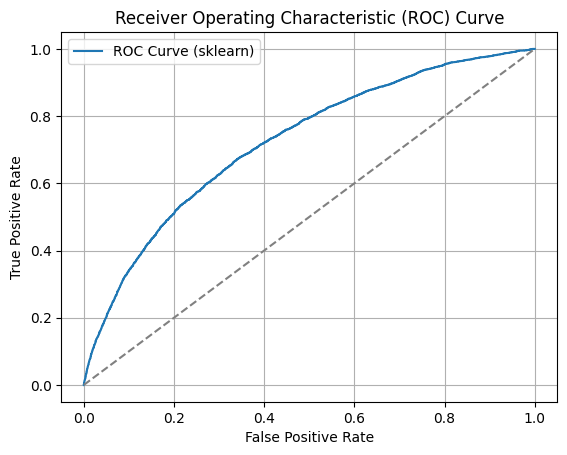

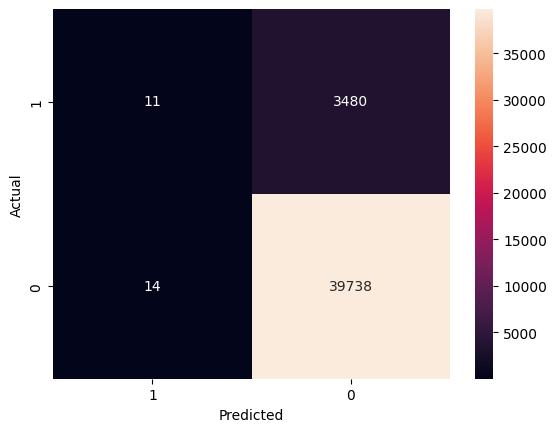

Model run: 95d197b2e5594822827fd6eb62a6fef7


e:\Mes Documents\_Open Classroom\Code\p7\p7env\lib\site-packages\_distutils_hack\__init__.py:18: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
e:\Mes Documents\_Open Classroom\Code\p7\p7env\lib\site-packages\_distutils_hack\__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


<Figure size 640x480 with 0 Axes>

In [41]:
# Traçage de l'expérience
mlflow.set_experiment("Test de mlflow sur une reg log sans recherche hyper-param ni weight_calsses")
with mlflow.start_run(run_name="Premier run expérimental") as run:
    # Entraînement
    train_mlflow(sk_model, X_train_imputed, y_train)
    # Validation
    dic_metrics = evaluate_mlflow(sk_model, X_val_imputed, y_val)
    
    # Log  metrics that were calculated during validation
    mlflow.log_metrics(dic_metrics)
    # Log the parameters used for the model fit
    mlflow.log_params(sk_model.get_params())
    # Log an instance of the trained model for later use
    #mlflow.sklearn.log_model(sk_model=rf, input_example=X_val, artifact_path=artifact_path)
    mlflow.sklearn.log_model(sk_model, "Test 0 de mlflow sur une reg log")
    print("Model run:", mlflow.active_run().info.run_uuid)
    print("run.info :", run.info)
# Force mlflow à terminer le run même s'il y a une erreur dedans
mlflow.end_run()



Voir le résultat dans un navigateur
Dans firefox, http://http://127.0.0.1:8080

# Sauvegarde du modèle

In [42]:
joblib.dump(sk_model, os.path.join(MODEL_DIR, "clf_reglog_test0.pkl"))

['models/clf_reglog_test0.pkl']

# MLFlow

Démarrer le serveur mlflow

In [ ]:
"""
Démarrer un serveur mlflow en local :
mlflow server --host 127.0.0.1 --port 8080
"""

'\nDémarrer un serveur mlflow en local :\nmlflow server --host 127.0.0.1 --port 8080\n'

Initialiser un client mlflow

In [ ]:
# NOTE: review the links mentioned above for guidance on connecting to a managed tracking server, such as the free Databricks Community Edition

client = MlflowClient(tracking_uri="http://127.0.0.1:8080")

Création d'une nouvelle expérience mlflow

In [ ]:
"""experiment_description = (
    "OC P7 Implémentez un modèle de Scoring"
    "Modèle LightGBM - Mode Debug"
)

experiment_tags = {
    "project_name": "p7",
    "store_dept": "produce",
    "team": "oc",
    "project_quarter": "Q1-2024",
    "mlflow.note.content": experiment_description,
}

lightgbm_debug_experiment = client.create_experiment(name="lightgbm_debug", tags=experiment_tags)"""

'experiment_description = (\n    "OC P7 Implémentez un modèle de Scoring"\n    "Modèle LightGBM - Mode Debug"\n)\n\nexperiment_tags = {\n    "project_name": "p7",\n    "store_dept": "produce",\n    "team": "oc",\n    "project_quarter": "Q1-2024",\n    "mlflow.note.content": experiment_description,\n}\n\nlightgbm_debug_experiment = client.create_experiment(name="lightgbm_debug", tags=experiment_tags)'

Rechercher l'expérience avec le nom du projet

In [ ]:
# Use search_experiments() to search on the project_name tag key

lightgbm_debug_experiment = client.search_experiments(
    filter_string="tags.'project_name' = 'p7'"
)

pprint(lightgbm_debug_experiment[0])

<Experiment: artifact_location='mlflow-artifacts:/768052023167465751', creation_time=1713797424132, experiment_id='768052023167465751', last_update_time=1713797424132, lifecycle_stage='active', name='lightgbm_debug', tags={'mlflow.note.content': 'OC P7 Implémentez un modèle de ScoringModèle LightGBM '
                        '- Mode Debug',
 'project_name': 'p7',
 'project_quarter': 'Q1-2024',
 'store_dept': 'produce',
 'team': 'oc'}>


In [ ]:
# Access individual tag data

print(lightgbm_debug_experiment[0].tags["team"])

oc


## Démarrer un run mlflow

In [ ]:
import mlflow

# Use the fluent API to set the tracking uri and the active experiment
mlflow.set_tracking_uri("http://127.0.0.1:8080")

# Sets the current active experiment to the "Apple_Models" experiment and returns the Experiment metadata
lightgbm_debug_experiment = mlflow.set_experiment("lightgbm_debug")

# Define a run name for this iteration of training.
# If this is not set, a unique name will be auto-generated for your run.
run_name = "lightgbm_debug_test"

# Define an artifact path that the model will be saved to.
artifact_path = "lightgbm_debug"

In [14]:
# Split the data into features and target and drop irrelevant date field and target field
X = data.drop(columns=["date", "demand"])
y = data["demand"]

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

"""params = {
    "n_estimators": 100,
    "max_depth": 6,
    "min_samples_split": 10,
    "min_samples_leaf": 4,
    "bootstrap": True,
    "oob_score": False,
    "random_state": 888,
}"""

LIGHTGBM_PARAMS = {
    "boosting_type": "goss",
    "n_estimators": 10000,
    "learning_rate": 0.005134,
    "num_leaves": 54,
    "max_depth": 10,
    "subsample_for_bin": 240000,
    "reg_alpha": 0.436193,
    "reg_lambda": 0.479169,
    "colsample_bytree": 0.508716,
    "min_split_gain": 0.024766,
    "subsample": 1,
    "is_unbalance": False,
    "silent": -1,
    "verbose": -1,
}

# Train the RandomForestRegressor
rf = RandomForestRegressor(**params)

# Fit the model on the training data
rf.fit(X_train, y_train)

# Predict on the validation set
y_pred = rf.predict(X_val)

# Calculate error metrics
mae = mean_absolute_error(y_val, y_pred)
mse = mean_squared_error(y_val, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_val, y_pred)

# Assemble the metrics we're going to write into a collection
metrics = {"mae": mae, "mse": mse, "rmse": rmse, "r2": r2}

# Initiate the MLflow run context
with mlflow.start_run(run_name=run_name) as run:
    # Log the parameters used for the model fit
    mlflow.log_params(LIGHTGBM_PARAMS)

    # Log the error metrics that were calculated during validation
    mlflow.log_metrics(metrics)

    # Log an instance of the trained model for later use
    mlflow.sklearn.log_model(sk_model=rf, input_example=X_val, artifact_path=artifact_path)

2024/04/20 10:03:40 WARNING mlflow.utils.git_utils: Failed to import Git (the Git executable is probably not on your PATH), so Git SHA is not available. Error: Failed to initialize: Bad git executable.
The git executable must be specified in one of the following ways:
    - be included in your $PATH
    - be set via $GIT_PYTHON_GIT_EXECUTABLE
    - explicitly set via git.refresh(<full-path-to-git-executable>)

All git commands will error until this is rectified.

This initial message can be silenced or aggravated in the future by setting the
$GIT_PYTHON_REFRESH environment variable. Use one of the following values:
    - quiet|q|silence|s|silent|none|n|0: for no message or exception
    - warn|w|warning|log|l|1: for a warning message (logging level CRITICAL, displayed by default)
    - error|e|exception|raise|r|2: for a raised exception

Example:
    export GIT_PYTHON_REFRESH=quiet

e:\Mes Documents\_Open Classroom\Code\p7\p7env\lib\site-packages\mlflow\types\utils.py:394: UserWarning:

#### Success!

You've just logged your first MLflow model! 

Navigate to the MLflow UI to see the run that was just created (named "apples_rf_test", logged to the Experiment "Apple_Models"). 